In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
import time
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
    torch.cuda.empty_cache()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder('dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model_a = models.vgg16(pretrained=True)
model_a.classifier[-1] = nn.Linear(4096, 1)
model_a = model_a.to(device)

model_b = models.vgg16(pretrained=True)
for param in model_b.features.parameters():
    param.requires_grad = False
model_b.classifier[-1] = nn.Linear(4096, 1)
model_b = model_b.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer_a = Adam(model_a.parameters(), lr=0.0001)
optimizer_b = Adam(filter(lambda p: p.requires_grad, model_b.parameters()), lr=0.0001)

/home/sriv/PycharmProjects/Insanity-ES335-4/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sriv/PycharmProjects/Insanity-ES335-4/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def train_model(model, optimizer, num_epochs=20):
    model.train()
    iteration = 0

    epoch_loss = float('inf')
    epoch_acc = 0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.view(-1, 1).float()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            predicted = torch.sigmoid(outputs).round()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Log scalars
            writer.add_scalar("Training Loss", loss.item(), iteration)
            writer.add_scalar("Training Accuracy", correct / total * 100, iteration)
            test_model(model, iteration)
            model.train()

            iteration += 1

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total * 100
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    print(f"Training loss: {epoch_loss:.4f}")
    print(f"Training accuracy: {epoch_acc:.2f}%")

    return model


def test_model(model, iteration=-1):
    model.eval()
    correct = total = 0

    img_cnt = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs).round()
            correct += (predicted.view(-1) == labels).sum().item()
            total += labels.size(0)
            
            for i in range(len(labels)):
                img_cnt += 1

                img_grid = inputs[i].cpu()

                if iteration == -1:
                    writer.add_image(f"Test Image {img_cnt} - Prediction: {int(predicted[i].item())}, Actual: {int(labels[i].item())}", img_grid, 0)

    accuracy = correct / total * 100
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    if iteration != -1:
        writer.add_scalar(f"Test Accuracy", accuracy, iteration)


In [6]:
start_time = time.time()
print('VGG16 including convolution layers - ')
writer = SummaryWriter("runs/vgg16_all")
model_a = train_model(model_a, optimizer_a)
print(f'Training time: {time.time() - start_time:.2f}s')
print('Number of parameters: ', sum(p.numel() for p in model_a.parameters() if p.requires_grad))
test_model(model_a)

VGG16 including convolution layers - 
Test Accuracy: 85.00%
Test Accuracy: 90.00%
Test Accuracy: 90.00%
Test Accuracy: 92.50%
Test Accuracy: 77.50%
Test Accuracy: 87.50%
Test Accuracy: 92.50%
Test Accuracy: 97.50%
Test Accuracy: 95.00%
Test Accuracy: 95.00%
Test Accuracy: 97.50%
Test Accuracy: 100.00%
Test Accuracy: 97.50%
Test Accuracy: 92.50%
Test Accuracy: 75.00%
Test Accuracy: 90.00%
Test Accuracy: 100.00%
Test Accuracy: 87.50%
Test Accuracy: 67.50%
Test Accuracy: 77.50%
Test Accuracy: 87.50%
Test Accuracy: 95.00%
Test Accuracy: 95.00%
Test Accuracy: 87.50%
Epoch [1/20], Loss: 0.4225, Accuracy: 86.46%
Test Accuracy: 85.00%
Test Accuracy: 72.50%
Test Accuracy: 70.00%
Test Accuracy: 70.00%
Test Accuracy: 70.00%
Test Accuracy: 85.00%
Test Accuracy: 90.00%
Test Accuracy: 92.50%
Test Accuracy: 90.00%
Test Accuracy: 90.00%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 95.00%
Test Accuracy: 95.00%
Test Accuracy: 92.50%
Test Accuracy

In [5]:

start_time = time.time()
print('VGG16 only MLP layers - ')
writer = SummaryWriter("runs/vgg16_mlp")
model_b = train_model(model_b, optimizer_b)
print(f'Training time: {time.time() - start_time:.2f}s')
print('Number of parameters: ', sum(p.numel() for p in model_b.parameters() if p.requires_grad))
test_model(model_b)

VGG16 only MLP layers - 
Test Accuracy: 90.00%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Epoch [1/20], Loss: 0.2860, Accuracy: 86.46%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Epoch [2/20], Loss: 0.0356, Accuracy: 98.96%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 100.00%
Test Accuracy: 100.00%
Test Accuracy: 100.00%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
Epoch [3/20], Loss: 0.0106, Accuracy: 99.48%
Test Accuracy: 97.50%
Test Accuracy: 97.50%
T

In [6]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder('dataset/train', transform=transform)
test_dataset = datasets.ImageFolder('dataset/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


class MLP(nn.Module):
    def __init__(self, input_size=64 * 64 * 3, num_classes=1):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(input_size, 8192),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x


mlp_model = MLP().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer_mlp = Adam(mlp_model.parameters(), lr=1e-3)


def train_model(model, optimizer, num_epochs=20):
    model.train()
    epoch_loss = float('inf')
    epoch_acc = 0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            predicted = torch.sigmoid(outputs).round()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total * 100
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    print(f"Training loss: {epoch_loss:.4f}")
    print(f"Training accuracy: {epoch_acc:.2f}%")

    return model

In [7]:
def test_model_show_misclassified(model):
    model.eval()
    correct = 0
    total = 0
    misclassified = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs).round()

            correct += (predicted.view(-1) == labels).sum().item()
            total += labels.size(0)

            for img, true_label, pred_label in zip(inputs, labels, predicted):
                if true_label != pred_label:
                    misclassified.append((img.cpu(), true_label.item(), pred_label.item()))

    accuracy = correct / total * 100
    print(f'Test Accuracy: {accuracy:.2f}%')

    if misclassified:
        print(f"Number of misclassified images: {len(misclassified)}")
        num_to_show = min(8, len(misclassified))
        fig, axes = plt.subplots(1, num_to_show, figsize=(15, 5))
        for i, (img, true_label, pred_label) in enumerate(misclassified[:num_to_show]):
            img = img.permute(1, 2, 0).numpy()
            img = np.clip(img, 0, 1)
            axes[i].imshow(img)
            axes[i].set_title(f'True: {true_label}, Pred: {pred_label}')
            axes[i].axis('off')
        plt.show()
    else:
        print("No misclassified images found!")

MLP Model - 
Epoch [1/20], Loss: 5.3268, Accuracy: 49.48%
Epoch [2/20], Loss: 0.8327, Accuracy: 55.73%
Epoch [3/20], Loss: 0.7347, Accuracy: 60.42%
Epoch [4/20], Loss: 0.7362, Accuracy: 59.38%
Epoch [5/20], Loss: 0.6722, Accuracy: 57.81%
Epoch [6/20], Loss: 0.6792, Accuracy: 60.94%
Epoch [7/20], Loss: 0.6560, Accuracy: 61.98%
Epoch [8/20], Loss: 0.6941, Accuracy: 66.67%
Epoch [9/20], Loss: 0.7760, Accuracy: 55.21%
Epoch [10/20], Loss: 0.6704, Accuracy: 61.98%
Epoch [11/20], Loss: 0.6647, Accuracy: 58.85%
Epoch [12/20], Loss: 0.6714, Accuracy: 55.73%
Epoch [13/20], Loss: 0.6363, Accuracy: 64.06%
Epoch [14/20], Loss: 0.6900, Accuracy: 61.98%
Epoch [15/20], Loss: 0.6490, Accuracy: 58.85%
Epoch [16/20], Loss: 0.6246, Accuracy: 64.58%
Epoch [17/20], Loss: 0.6169, Accuracy: 61.46%
Epoch [18/20], Loss: 0.5992, Accuracy: 66.15%
Epoch [19/20], Loss: 0.6438, Accuracy: 52.60%
Epoch [20/20], Loss: 0.5424, Accuracy: 59.38%
Training loss: 0.5424
Training accuracy: 59.38%
Training time: 109.82s
Numbe

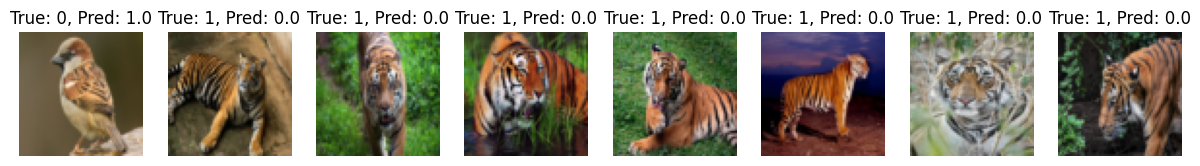

In [8]:
start_time = time.time()
print('MLP Model - ')
mlp_model = train_model(mlp_model, optimizer_mlp)
print(f'Training time: {time.time() - start_time:.2f}s')
print('Number of parameters: ', sum(p.numel() for p in mlp_model.parameters() if p.requires_grad))
test_model_show_misclassified(mlp_model)

Testing VGG16 Model with all layers tuned
Test Accuracy: 1.0000
Number of images: 4


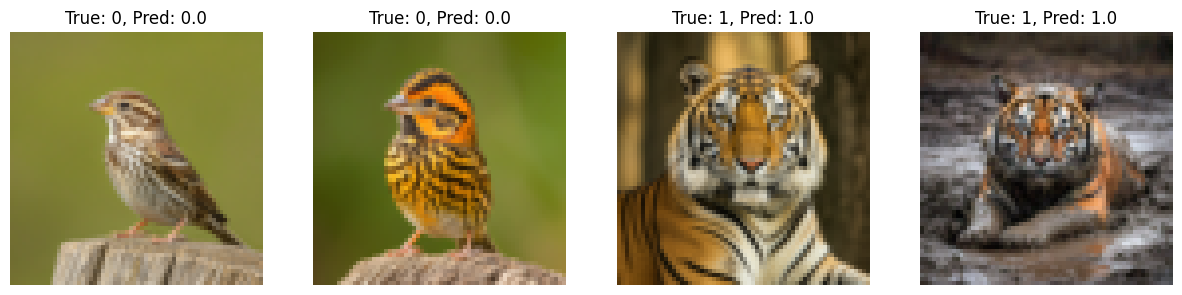

Testing VGG16 Model with only MLP layers tuned
Test Accuracy: 1.0000
Number of images: 4


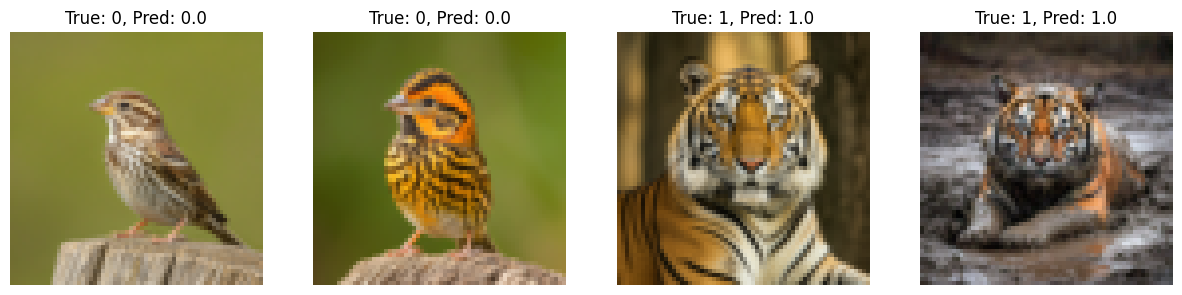

Evaluating MLP Model
Test Accuracy: 0.7500
Number of images: 4


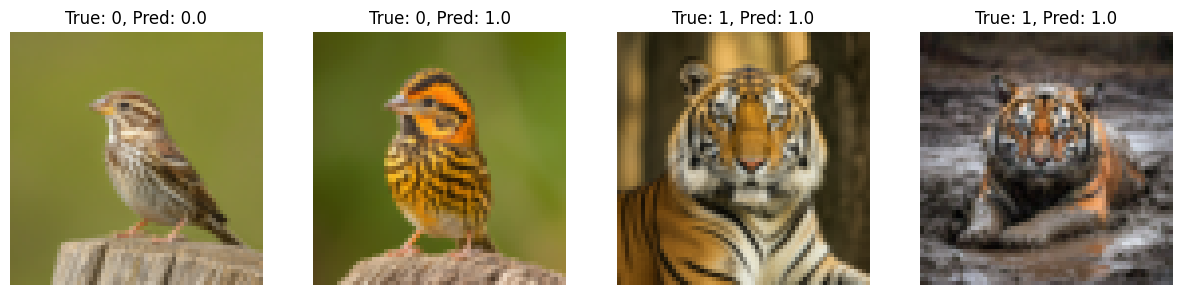

In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

mlp_model.eval()

test_dataset = datasets.ImageFolder('./Generated-Images', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


def test_model_image_generation(model):
    model.eval()
    correct = 0
    total = 0
    results = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = torch.sigmoid(outputs).round()

            correct += (predicted.view(-1) == labels).sum().item()
            total += labels.size(0)

            for img, true_label, pred_label in zip(inputs, labels, predicted):
                results.append((img.cpu(), true_label.item(), pred_label.item()))

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    print(f"Number of images: {len(results)}")
    num_to_show = min(8, len(results))
    fig, axes = plt.subplots(1, num_to_show, figsize=(15, 5))
    for i, (img, true_label, pred_label) in enumerate(results[:num_to_show]):
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_label}, Pred: {pred_label}')
        axes[i].axis('off')
    plt.show()


print("Testing VGG16 Model with all layers tuned")
test_model_image_generation(model_a)

print("Testing VGG16 Model with only MLP layers tuned")
test_model_image_generation(model_a)

print("Evaluating MLP Model")
test_model_image_generation(mlp_model)

Sparrow Easy:
Create an image of a brown sparrow, slightly zoomed out

Sparrow Hard:
Create an image of a sparrow that has the color scheme of a tiger, slightly zoomed out

Tiger Easy:
Create an image of a bengal tiger

Tiger Hard:
A tiger that has rolled in mud. The mud is on the tiger's face as well. It's fully covered in mud.